# Implementación de moldelo de deep learning
## **Tercer Modelo:** Modelo mejorado con las instrucciones del profesor

### Mariluz Daniela Sánchez Morales - A01422953

> **Caso**: Clasificación de enfermedades comunes del tórax.
>
> **Dataset**: [NIH Chest X-rays de Kaggle](https://www.kaggle.com/datasets/nih-chest-xrays/data "Link a Kaggle")

### **Desarrollo del Problema**: Detección de Enfermedades en Radiografías Torácicas con Deep Learning

La interpretación de radiografías torácicas es una tarea crucial en el diagnóstico médico, sin embargo, la detección precisa de estas enfermedades en las imágenes de rayos X presenta grandes desafíos debido a que muchos de estos signos patológicos suelen sobreponerse sobre otros. La interpretación de estas radiografías deben ser interpretadas por radiólogos expertos; sin embargo, día a día la demanda de exámenes radiológicos crece y uno de los desafíos es la poca disponibilidad o falta de especialistas en radiología por lo existe la necesidad de buscar tecnologías para solucionar esta escasez en el sector de la salud.

El objetivo de este proyecto es crear un modelo de deep learning que ayude a detectar automáticamente posibles enfermedades que puedan aparecer en radiografías torácicas proporcionando un “filtro preliminar” para identificar casos con alta probabilidad de alguna de las enfermedades comunes encontradas en el tórax. La automatización de esta tarea puede significar un gran apoyo en el área médica para la detección de anomalías en los casos que se presente.

Para este proyecto, se utilizó el NIH Chest X-ray Dataset de Kaggle, un conjunto de datos público que contiene más de 112,000 imágenes de rayos X etiquetadas con 14 tipos de enfermedades pulmonares y a su vez también clasifica casos donde no se encuentre enfermedad.

# Objetivo

El objetivo  de este código es mejorar el modelo inicial utilizando una arquitectura más avanzada inspirada en ResNet, con el fin de optimizar la clasificación multi-etiqueta de enfermedades comunes en el tórax.

Incluye mejoras como el preprocesamiento de imágenes, una codificación multi-hot de etiquetas para clasificar múltiples enfermedades por imagen, y el uso de unidades residuales personalizadas para capturar características específicas en las radiografías. 

Se hace uso de técnicas de data augmentation y regularización.

Aunque es más complejo, este enfoque logra una mayor precisión (accuracy de 0.609), acercándose más a una herramienta útil para la detección de múltiples enfermedades en imágenes médicas.Sin embargo debido a la complejidad del tema es importante buscar una mejora del modelo para acercarse a una mejor precisión.

In [31]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [32]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Carga y Filtrado de Datos

Asi como en el primer modelo se carga en un DataFrame de Pandas el archivo CSV donde se incluye únicamente las imágenes disponibles en el sistema, asegurando que el entrenamiento no fallará por intentos de acceso a archivos inexistentes.

## División de Datos en Conjuntos de Entrenamiento, Validación y Prueba

En esta misma sección se divide el conjunto de datos en 3 partes (train, validation, test) para garantizar que el modelo pueda evaluarse con datos desconocidos por el mismo durante el entrenamiento, esto con el fin de garantizar una mejor generalización del segundo modelo que a diferencia del primero, este separa el 30% de los datos para validación y prueba, manteniendo un 70% para el entrenamiento.


In [33]:
# Load the CSV into a DataFrame
df = pd.read_csv('Data_Entry_2017.csv')

# Define a single path to your image folder
image_folder = 'images_Train/images'

# List all available image files in the folder
all_images = set(os.listdir(image_folder))

# Filter the DataFrame for only images present in the folder
df = df[df['Image Index'].isin(all_images)]

# Use train_test_split to split the DataFrame
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Save the subsets to new CSV files (optional)
train_df.to_csv("train_labels.csv", index=False)
val_df.to_csv("val_labels.csv", index=False)
test_df.to_csv("test_labels.csv", index=False)

# Codificación de Etiquetas Multiclase como Vectores Multi-Hot

El modelo debe identificar múltiples enfermedades a partir de las radiografías, ya que cada imagen puede presentar varias condiciones puesto que estas enfermedades pueden aparecer sobrepuestas (p. ej., Cardiomegalia y Efusión). 
Por ello, el sistema necesita una codificación multi-hot para clasificar correctamente las radiografías con más de una enfermedad. Aquí:

- Cada enfermedad está asociada con un índice numérico.
- La función *process_labels* convierte las etiquetas de texto (p. ej., "Cardiomegaly") a un vector multi-hot en el que cada posición representa una enfermedad.
- Esto significa que, para cada imagen, el vector de etiquetas indicará con 1 si la enfermedad está presente y con 0 si no lo está.
- Este mapeo y codificación permiten que el modelo entienda las etiquetas como datos numéricos y pueda trabajar con imágenes que presentan más de una condición

Este enfoque es **esencial** para el problema y el modelo debe estar preparado para predecir múltiples etiquetas simultáneamente.

In [34]:
# Map disease names to integer labels
disease_to_label = {
    "Atelectasis": 0, "Cardiomegaly": 1, "Effusion": 2, "Infiltration": 3, 
    "Mass": 4, "Nodule": 5, "Pneumonia": 6, "Pneumothorax": 7, 
    "Consolidation": 8, "Edema": 9, "Emphysema": 10, "Fibrosis": 11, 
    "Pleural_Thickening": 12, "Hernia": 13, "No Finding": 14
}

In [35]:
# Return a multi-hot encoded label vector
def process_labels(label_str):
    labels = label_str.split('|')
    label_vector = [0] * len(disease_to_label)  # Initialize vector with zeros
    for label in labels:
        label_index = disease_to_label[label]
        label_vector[label_index] = 1  # Set position to 1 for each disease present
    return label_vector

# Preprocesamiento y Carga de Imágenes en TensorFlow Datasets

En este caso se crea la función *load_image* que se encarga de decodificar las imágenes y las redimensiona a un tamaño consistente de 244x244 píxeles. Esto con el fin de estandarizar las entradas al modelo y facilita la eficiencia en procesamiento y entrenamiento.


In [36]:
# Load and preprocess images
def load_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [244, 244])
    return img, label

# Preparación de Conjuntos de Datos para Entrenamiento, Validación y Prueba 

Para que el modelo pueda entrenarse sin problemas, se debe organizar el dataset en un formato adecuado y las imágenes deben estar preprocesadas:

1. **Obtener rutas y etiquetas:** se obtienen las rutas de las imágenes y se transforman las etiquetas en vectores multi-hot.
2. **Preprocesamiento de imágenes:**
    - Las imágenes se cargan y se redimensionan a 244x244 píxeles para uniformidad en el modelo.
3. **Creación del dataset:** se transforma el dataset en un tf.data.Dataset, optimizando la carga en mini-lotes de tamaño 32 para facilitar el entrenamiento.

Esto facilita la carga en memoria durante el entrenamiento y es fundamental para que el modelo procese datos de manera eficiente.

In [37]:
# Prepare datasets for training, validation, and test
def prepare_dataset(df, folder_path):
    # Get file paths and labels
    image_paths = [os.path.join(folder_path, fname) for fname in df["Image Index"].values]
    labels = [process_labels(lbl) for lbl in df["Finding Labels"].values]

    # Convert multi-labels to a multi-hot encoded vector
    labels = tf.keras.preprocessing.sequence.pad_sequences(labels, maxlen=15, dtype='int32', padding="post", value=0)
    
    # Create TensorFlow dataset
    file_paths_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    image_label_dataset = file_paths_dataset.map(lambda path, label: load_image(path, label))
    return image_label_dataset.batch(32)

In [38]:
# Create datasets 
train_dataset = prepare_dataset(train_df, image_folder)
val_dataset = prepare_dataset(val_df, image_folder)
test_dataset = prepare_dataset(test_df, image_folder)

# Arquitectura de la Unidad Residual Personalizada

Finalmente se crea la arquitectura ResNet la cual mejora el entrenamiento de redes profundas al permitir que las características aprendidas en capas previas pasen directamente a capas que le siguen. 

En este caso, esta característica resulta útil en este caso ya que se necesita aprender patrones sutiles y no lineales en los datos puesto que las radriografías normalmente presentan estas caracteristicas complejas. 

En esta sección se define la unidad residual que facilitará que que lo aprendido durante el entrenamiento se trasnmitan eficientemente, además las conexiones residuales ayudan a evitar que el modelo pierda precisión a medida que aumenta la profundidad de la red

De igual forma se incluyen capas Dropout y Batch Normalization para reducir el sobreajuste principalmente por la reduccuin del dataset que se hizo para evitar problemas con el procesamiento computacional.

In [39]:
# Custom Residual Unit class
@keras.utils.register_keras_serializable()
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False, kernel_regularizer=keras.regularizers.l2(0.01)),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Dropout(0.3),  # Added dropout
            keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False, kernel_regularizer=keras.regularizers.l2(0.01)),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False, kernel_regularizer=keras.regularizers.l2(0.01)),
                keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

# Definición y Configuración del Modelo

Este modelo utiliza una arquitectura similar a ResNet, pero fue adaprada para que realizara la clasificación multietiqueta. En el modelo podemos ver diferentes capas:

1. **Data augmentation:** Ayuda a crear variaciones de las imágenes, para asegurar ña robustez del modelo ante cambios en la orientación y escalado de las imágenes. Esto es importante porque las radiografías pueden variar en estos aspectos.

2. **Arquitectura profunda:** Las capas convolucionales iniciales aprenden características básicas de las imágenes, mientras que las unidades residuales en las capas más profundas capturan patrones complejos. Estas se encargarán de detectar multiples enfermadades que puedan presnetar las imágenes.

3. **Salida sigmoid:** Un cambio importante a mencionar es que en este segundo modelo se usa una capa Dense con activación sigmoid en lugar de softmax, ya que sigmoid permite que se activen múltiples neuronas al mismo tiempo, en línea con el enfoque multi-hot.

In [41]:
# Model definition
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(244, 244, 3)))

# Data augmentation and scaling
model.add(keras.layers.RandomFlip("horizontal"))
model.add(keras.layers.RandomRotation(0.1))
model.add(keras.layers.RandomZoom(0.2))

# ResNet-like architecture
model.add(keras.layers.Conv2D(64, 7, strides=2, padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(15, activation="sigmoid"))  # 15 classes (14 diseases + No Finding)

# Compilación del Modelo y Configuración de Callbacks

Otro cambio importante en este segundo modelo es que se utiliza la pérdida binary_crossentropy, que calcula la pérdida para cada etiqueta de manera independiente pues en este caso queremos saber todas las posibles enfermedades que se puedan presentar y no solo una.

Descripción de las demás métricas que se utilizan:

1. **Optimizador Adam:** ayuda a ajustar los pesos del modelo con una tasa de aprendizaje adaptativa, siendo eficiente en términos de recursos y adecuado para este tipo de redes profundas.

2. **Callbacks:**
    - *ModelCheckpoint* guarda el mejor modelo en función de la pérdida de validación, lo cual es importante para evitar sobreajuste.
    - *EarlyStopping* finaliza el entrenamiento si el modelo deja de mejorar en validación después de 10 épocas, lo cual ahorra tiempo y recursos.


In [42]:
# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        "accuracy",
        keras.metrics.AUC(name="AUC"),
        keras.metrics.Precision(name="Precision"),
        keras.metrics.Recall(name="Recall"),
        keras.metrics.TopKCategoricalAccuracy(k=5, name="Top5Accuracy")
    ]
)

In [43]:
# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="chest_xray_resnet_v2.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
]

In [44]:
class_weights = {0: 1.0, 1: 1.5, 2: 1.2, 3: 0.8}  # Ajusta según el desbalance

# Entrenamiento del Modelo

Se entrena el modelo con los datos de entrenamiento, por un total de 10 épocas. El proceso de entrenamiento se lleva a cabo en paralelo con el conjunto de validación, lo que permite monitorear el rendimiento del modelo en datos no vistos.

De igual forma por la limitación de procesamiento, los periodos de entrenamiento son bajos.

In [46]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1036s 5s/step - AUC: 0.7812 - Precision: 0.4325 - Recall: 0.3477 - Top5Accuracy: 0.7922 - accuracy: 0.5112 - loss: 17.9181 - val_AUC: 0.8476 - val_Precision: 0.6067 - val_Recall: 0.5092 - val_Top5Accuracy: 0.8873 - val_accuracy: 0.6067 - val_loss: 0.4359 - learning_rate: 0.0010
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1023s 5s/step - AUC: 0.8143 - Precision: 0.5899 - Recall: 0.3557 - Top5Accuracy: 0.8298 - accuracy: 0.5826 - loss: 0.4827 - val_AUC: 0.8417 - val_Precision: 0.6067 - val_Recall: 0.5092 - val_Top5Accuracy: 0.8727 - val_accuracy: 0.6067 - val_loss: 0.4340 - learning_rate: 0.0010
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 976s 4s/step - AUC: 0.8167 - Precision: 0.5748 - Recall: 0.3669 - Top5Accuracy: 0.8376 - accuracy: 0.5795 - loss: 0.6283 - val_AUC: 0.8117 - val_Precision: 0.6067 - val_Recall: 0.5092 - val_Top5Accuracy: 0.8847 - val_accuracy: 0.6067 - val_loss: 0.8331 - learning_rate: 0.0010
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 985s 5

# Visualización de Resultados


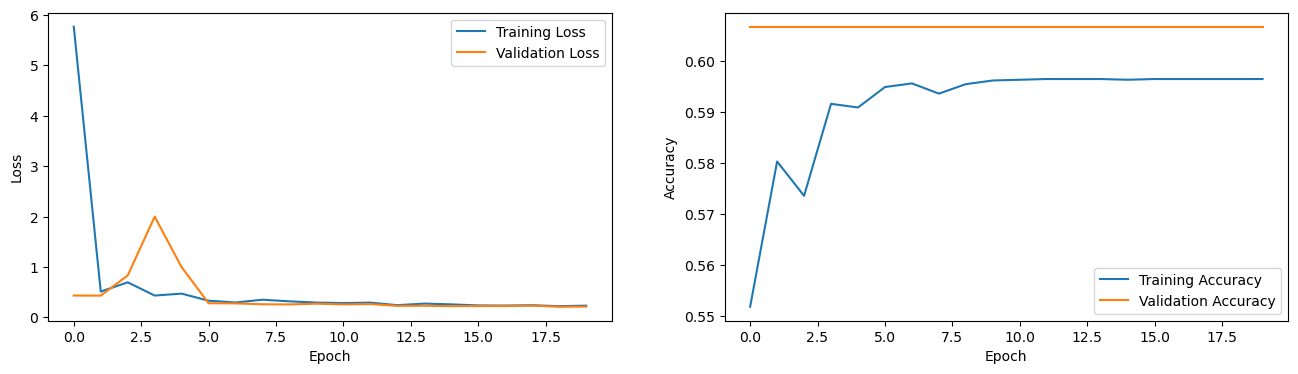

In [47]:
# Graficación de los resultados del entrenamiento
plt.figure(figsize=(16, 4))

# Gráfica de pérdida
plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Gráfica de accuracy
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [48]:
# Evaluate the model
test_loss, test_accuracy, test_auc, test_precision, test_recall, test_top5 = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Top-5 Accuracy: {test_top5:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 44s 925ms/step - AUC: 0.8409 - Precision: 0.5961 - Recall: 0.5019 - Top5Accuracy: 0.8664 - accuracy: 0.5961 - loss: 0.2168
Test Accuracy: 0.6093
Test AUC: 0.8514
Test Precision: 0.6093
Test Recall: 0.5181
Test Top-5 Accuracy: 0.8693


47/47 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step


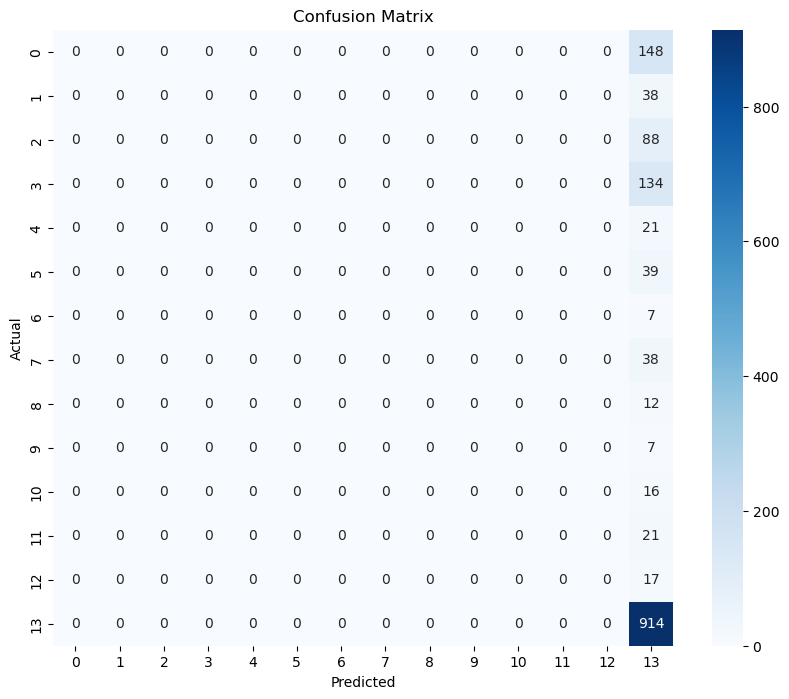

In [49]:
# Predictions for confusion matrix
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Conclusión

El segundo modelo emplea una arquitectura basada en ResNet, diseñada específicamente para mejorar la capacidad de detección de múltiples enfermedades en radiografías mediante una red residual. 

Con técnicas avanzadas como data augmentation, codificación multi-hot de etiquetas, y unidades residuales personalizadas, el modelo muestra una mejora notable en precisión (0.609). 

Sin embargo, esta precisión aún deja espacio para mejorar y sugiere que la reducción del conjunto de datos podría estar afectando el rendimiento.Este bajo rendimiento se le puede atribuir a la seleccion manual de los datos para reducir el procesamiento computacional lo que puede resultar en un mal balanceamento de datos que se puede inclinar a una sola clase.


Este enfoque más profundo confirma que la arquitectura influye significativamente en la capacidad de clasificación, y establece una base sólida para futuras mejoras en aplicaciones médicas de deep learning.

# Predicción

In [50]:
from tensorflow.keras.utils import load_img, img_to_array

In [51]:
labels = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
    "Mass", "Nodule", "Pneumonia", "Pneumothorax",
    "Consolidation", "Edema", "Emphysema", "Fibrosis",
    "Pleural Thickening", "Hernia", "No Finding"
]

In [60]:
df_pred = pd.read_csv("Data_Entry_2017.csv") 

In [81]:
def predict_image(img_path, model, labels):
    # Cargar y procesar la imagen
    img = load_img(img_path, target_size=(244, 244))  # Usar load_img de keras.utils
    img_array = img_to_array(img)  # Convertir la imagen a un array
    img_array = np.expand_dims(img_array, axis=0)  # Agregar dimensión batch
    img_array = img_array / 255.0  # Normalizar la imagen

    # Hacer la predicción
    predictions = model.predict(img_array, verbose=0)  # verbose=0 para evitar logs excesivos
    predictions = predictions[0]  # Extraer la primera fila de predicciones (ya que es batch de 1)

    # Ordenar las predicciones de mayor a menor probabilidad
    sorted_indices = np.argsort(predictions)[::-1]  # Índices ordenados en orden descendente
    top_5_indices = sorted_indices[:5]  # Obtener los índices de las 5 predicciones más altas
    top_5_labels = [(labels[i], predictions[i]) for i in top_5_indices]

    # Mostrar las 5 predicciones más probables
    formatted_top_5 = "\n".join([f"{label}: {prob:.2f}" for label, prob in top_5_labels])

     # Extraer el nombre de la imagen y buscar en el CSV
    img_name = img_path.split("/")[-1] # Extraer el nombre base sin extensión
    real_value = df_pred.loc[df_pred["Image Index"] == img_name, "Finding Labels"].values  # Buscar en el DataFrame

    # Construir la salida deseada
    print("Top 5 predicciones más probables:")
    print(formatted_top_5)

    if real_value.size > 0:
        print(f"\nEtiquetas reales de la imagen {img_name} en el CSV: {real_value[0]}")
    else:
        print(f"\nEtiquetas reales de la imagen {img_name} en el CSV: No se encontró.")

In [82]:
# Llamar a la función con la ruta de la imagen a predecir
predict_image("image_Predict/00000143_002.png", model, labels)

Top 5 predicciones más probables:
No Finding: 0.51
Infiltration: 0.22
Effusion: 0.13
Atelectasis: 0.11
Consolidation: 0.06

Etiquetas reales de la imagen 00000143_002.png en el CSV: Effusion|Infiltration
